In [1]:
from math import pi

import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import ADSTFT, ADSTFTfix, ADSTFTenergy

device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device("mps")
print(device, torch.__version__)
torch.manual_seed(1802)

cpu 2.6.0


In [2]:
mat = loadmat("../data/fan_flutter.mat")["x"]
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]

def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

101
tensor(0.00366103951819241047, grad_fn=<AbsBackward0>)
tensor(0.00366104044951498508, grad_fn=<AbsBackward0>)
Elapsed time: 2.7650 seconds
Elapsed time: 0.8440 seconds
tensor(0.00366103951819241047, grad_fn=<AbsBackward0>)
tensor(0.00366103951819241047, grad_fn=<AbsBackward0>)
0.0
0.0
0.0


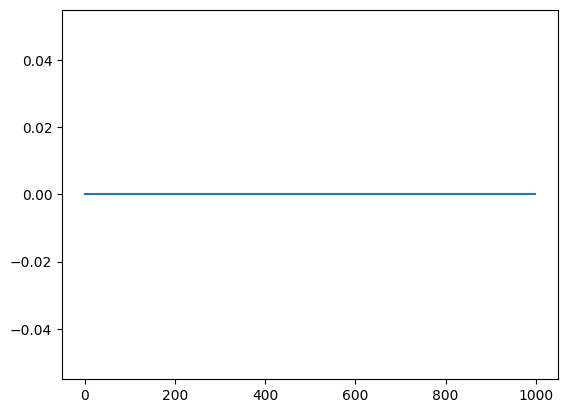

'\ndiff = specfix - spec\nprint(diff.shape)\nprint("specfix", specfix.shape)\nprint("spec", spec.shape)\nprint(diff[0, 500, 0])\nprint("diff", diff.max(), diff.min(), diff.mean())\ndiff_f = diff.squeeze(0).mean(dim=1).detach().numpy()\nplt.plot(diff_f[-10:])\nplt.show()\nadstft.plot(diff, x, bar=True, wins=False, weights=False)\n\nbackdiff = specbackfix - specback\nprint("diff", backdiff.max(), backdiff.min(), backdiff.mean())\nbackdiff_f = backdiff.squeeze(0).mean(dim=1).detach().numpy()\nplt.plot(backdiff_f[-10:])\nplt.show()\nadstft.plot(backdiff, x, bar=True, wins=False, weights=False)\n'

In [6]:
#dstftdev = DSTFTdev(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
#               ).to(device)
#tic()
#specdev, *_ = dstftdev(x)
#toc()
adstftfix = ADSTFTfix(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)
tic()
specfix, *_ = adstftfix(x)
coefffix = adstftfix.kasper
tapfix = adstftfix.tapered_x[0, 0, 500, :]
#entropy_loss(specfix).backward()
#temp = adstftfix.win_length.grad
#print("temp", temp.shape)
#print("specfix", specfix.shape)
#adstftfix.plot(temp[None, :, :], x, bar=True, wins=False, weights=False)
#specbackfix = adstftfix.win_length.grad[:501, :]
toc()
adstft = ADSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)
tic()
spec, *_ = adstft(x)
coeff = adstft.kasper
tap = adstft.tapered_x[0, 0, 500, :]
#entropy_loss(spec).backward()
#specback = adstft.win_length.grad
toc()

torch.set_printoptions(precision=20)
print((coeff*tap).sum(dim=-1).abs())
print((coefffix*tapfix).sum(dim=-1).abs())
torch.set_printoptions(precision=4)

import numpy as np
diff = [np.abs(k.detach().numpy()-kf.detach().numpy()) for (k, kf) in zip(coeff, coefffix)]
print(np.min(diff))
print(np.max(diff))
print(np.mean(diff))
plt.plot(diff)
plt.show()

"""
diff = specfix - spec
print(diff.shape)
print("specfix", specfix.shape)
print("spec", spec.shape)
print(diff[0, 500, 0])
print("diff", diff.max(), diff.min(), diff.mean())
diff_f = diff.squeeze(0).mean(dim=1).detach().numpy()
plt.plot(diff_f[-10:])
plt.show()
adstft.plot(diff, x, bar=True, wins=False, weights=False)

backdiff = specbackfix - specback
print("diff", backdiff.max(), backdiff.min(), backdiff.mean())
backdiff_f = backdiff.squeeze(0).mean(dim=1).detach().numpy()
plt.plot(backdiff_f[-10:])
plt.show()
adstft.plot(backdiff, x, bar=True, wins=False, weights=False)
"""

CIAOu
174


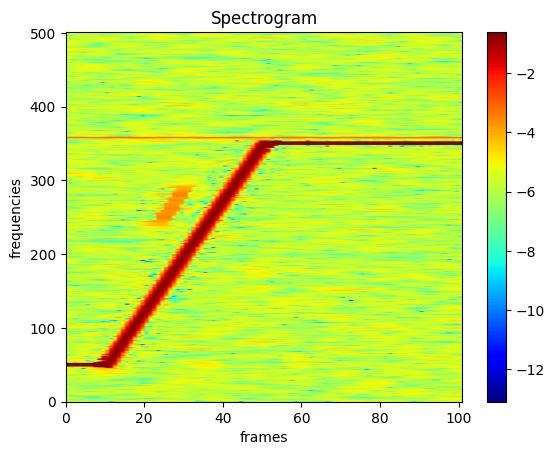

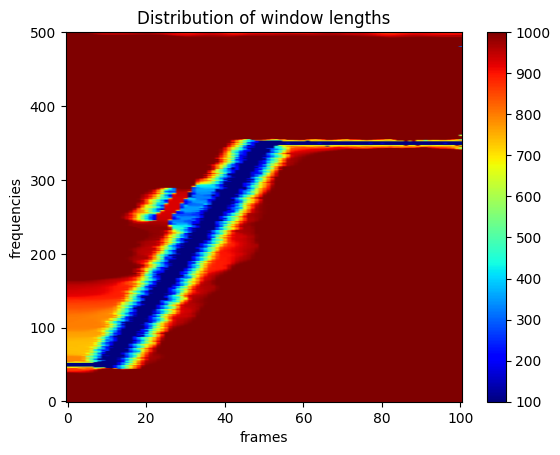

In [11]:
dstft = DSTFTdev(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/DSTFT/dstft/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


too short tensor(744)
too short tensor(941)
too long tensor(1)
too short tensor(984)
too long tensor(1)
too short tensor(1034)
too long tensor(1)
too short tensor(1053)
too long tensor(1)
too short tensor(1140)
too long tensor(1)
too short tensor(1302)
too long tensor(1)
too short tensor(1496)
too long tensor(1)
too short tensor(1592)
too short tensor(1621)
too short tensor(1634)
too short tensor(1647)
too long tensor(1)
too short tensor(1654)
too long tensor(1)
too short tensor(1665)
too long tensor(1)
too short tensor(1670)
too long tensor(1)
too short tensor(1672)
too long tensor(2)
too short tensor(1672)
too long tensor(2)
too short tensor(1675)
too long tensor(2)
too short tensor(1678)
too long tensor(2)
too short tensor(1680)
too long tensor(2)
too short tensor(1681)
too long tensor(2)
too short tensor(1681)
too long tensor(2)
too short tensor(1684)
too long tensor(2)
too short tensor(1685)
too long tensor(2)
too short tensor(1686)
too long tensor(2)
too short tensor(1688)
too lo

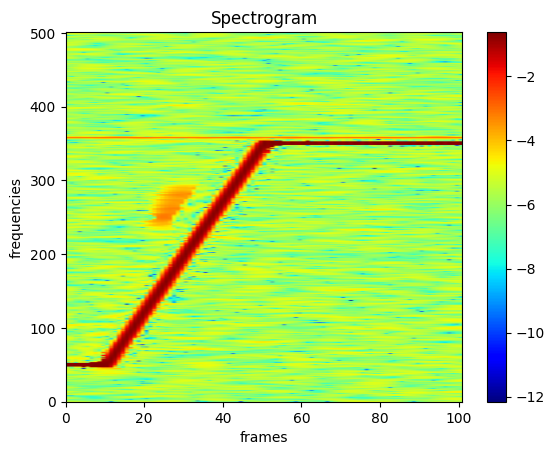

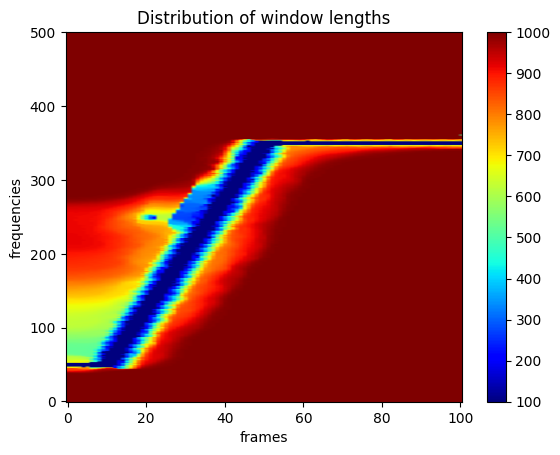

In [7]:
dstft = ADSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)

    toolong = (dstft.win_length > 1000).sum()
    if toolong > 0:
        print("too long", toolong)
    tooshort = (dstft.win_length < 50).sum()
    if tooshort > 0:
        print("too short", tooshort)
    with torch.no_grad():
        dstft.win_length.copy_(torch.clamp(dstft.win_length, min=50, max=1000))
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.plot(spec, x, bar=True, wins=False)

101
174


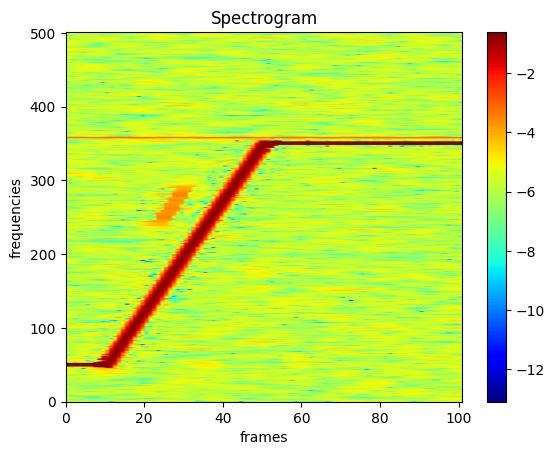

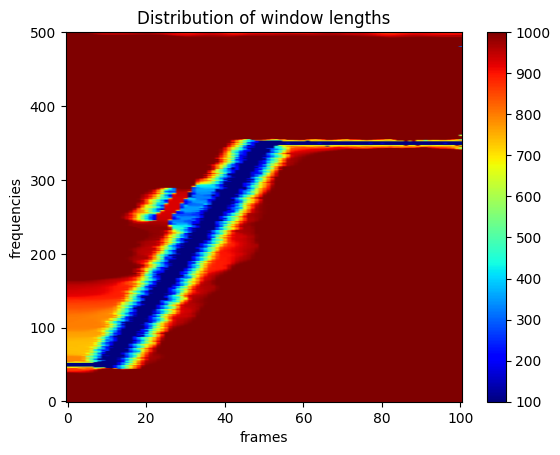

In [5]:
dstft = ADSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.plot(spec, x, bar=True, wins=False)

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/DSTFT/dstft/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


290


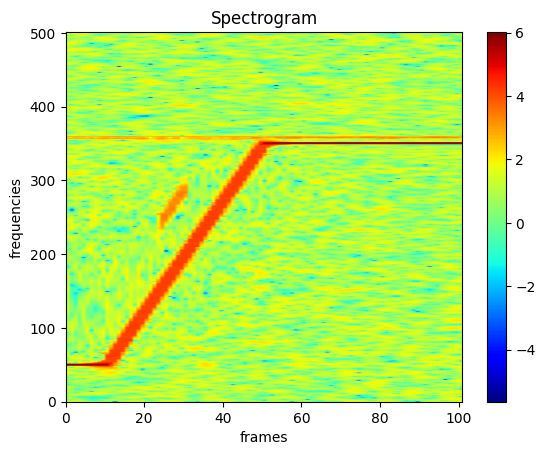

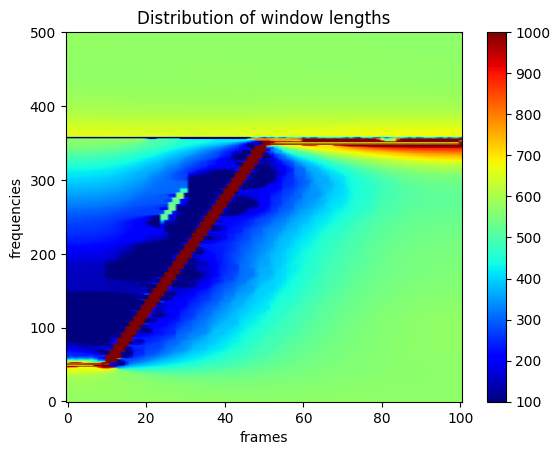

In [ ]:
dstft = ADSTFTenergy(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
spec, *_ = dstft.abs_forward(x)
dstft.plot(spec, x, bar=True, wins=False)

96


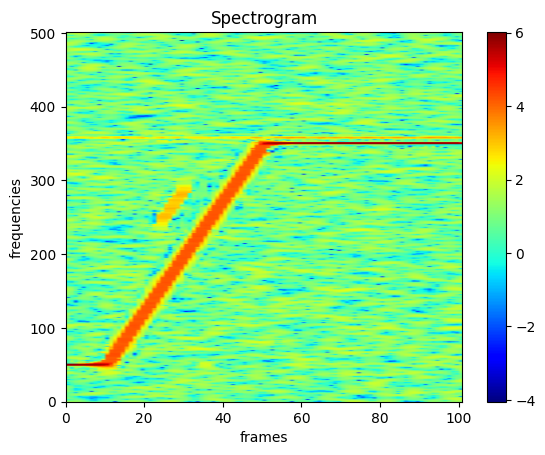

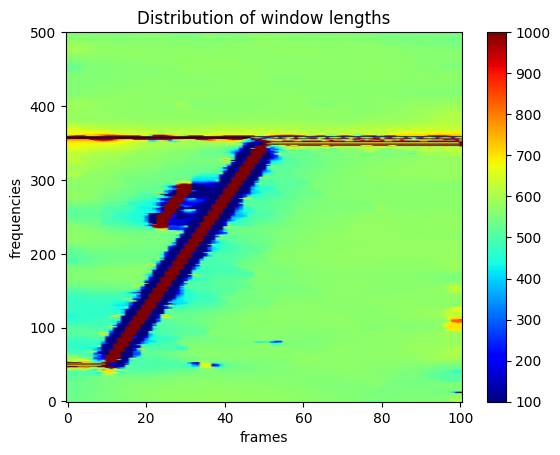

In [ ]:
dstft = ADSTFTenergy(x, win_length=1000, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
spec, *_ = dstft.abs_forward(x)
dstft.plot(spec, x, bar=True, wins=False)

87


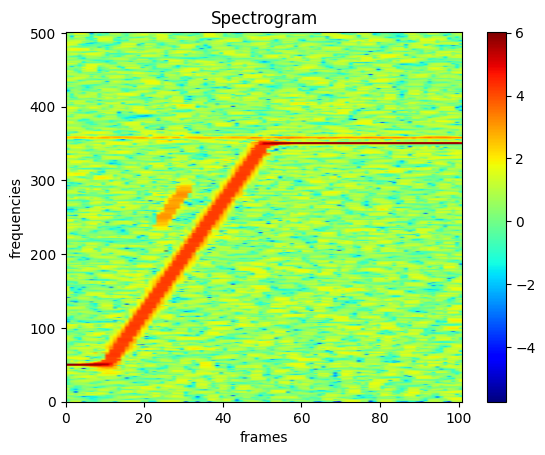

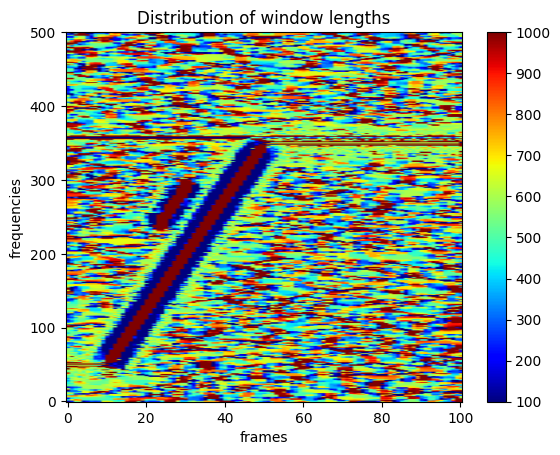

In [10]:
dstft = ADSTFTenergy(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.0001* (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
spec, *_ = dstft.abs_forward(x)
dstft.plot(spec, x, bar=True, wins=False)